## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import trange

import torch
from torch.utils.data import DataLoader

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

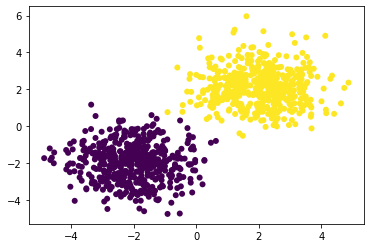

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

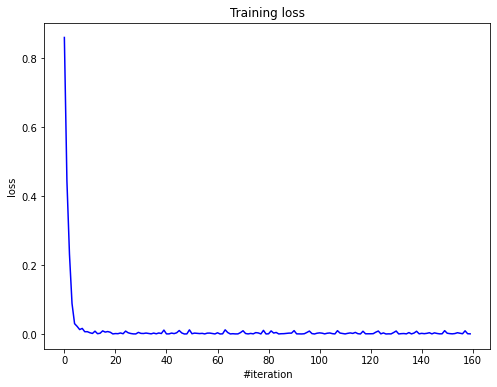

Current loss: 0.000393


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

num_classes = 10

One-hot encode the labels first.

In [ ]:
def encode_labels(y):
    batch_size = y.shape[0]
    tmp = np.zeros((batch_size, num_classes))
    tmp[range(batch_size), y] = 1
    return tmp

In [ ]:
y_train = encode_labels(y_train)
y_val   = encode_labels(y_val)
y_test  = encode_labels(y_test)

In [ ]:
def plain_data(x):
    return x.reshape((x.shape[0], x.shape[1] * x.shape[2]))

In [ ]:
X_train = plain_data(X_train)
X_val   = plain_data(X_val)
X_test  = plain_data(X_test)

In [ ]:
# batch generator
def get_batches(dataset, batch_size=128):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (followed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

Будем работать со следующей моделью:
 -  Linear 784 -> 20
 -  opt: BatchNormalization
 -  opt: ChannelwiseScaling
 -  activation
 -  Linear 20 -> 10
 -  LogSoftMax
 -  Flatten


In [ ]:
class Trainer:
    def __init__(self,
                 net=Sequential().add(Linear(784, 10)).add(ReLU()).add(Linear(10, 10)).add(LogSoftMax()).add(Flatten()),
                 criterion=ClassNLLCriterion(),
                 optimizer=sgd_momentum,
                 optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9},
                 optimizer_state = {},
                ):
        self.net = net
        self.criterion = criterion
        self.optimizer = optimizer
        self.optimizer_config = optimizer_config
        self.optimizer_state = optimizer_state
    
    def train(self, dataset, n_epoch=20, batch_size=128, visualize=False):
        loss_history = []
        self.net.train()

        for i in range(n_epoch):
            for x_batch, y_batch in get_batches(dataset, batch_size):

                self.net.zeroGradParameters()

                # Forward
                predictions = self.net.forward(x_batch)
                loss = self.criterion.forward(predictions, y_batch)

                # Backward
                dp = self.criterion.backward(predictions, y_batch)
                self.net.backward(x_batch, dp)

                # Update weights
                self.optimizer(self.net.getParameters(), 
                               self.net.getGradParameters(), 
                               self.optimizer_config,
                               self.optimizer_state)     

                loss_history.append(loss)

            # Visualize
            if visualize:
                display.clear_output(wait=True)
                plt.figure(figsize=(8, 6))
                
                plt.title("Training loss")
                plt.xlabel("#iteration")
                plt.ylabel("loss")
                plt.plot(loss_history, 'b')
                plt.show()

            print('Current loss: %f' % loss)

        self.loss_history = loss_history
        return (self.net, self.loss_history)
    
    def train_torch(self, dataset, n_epoch=20, batch_size=128, visualize=False):
        self.net.train(True)
        loss_history = []

        for i in range(n_epoch):
            for x_batch, y_batch in get_batches(dataset, batch_size):
                x_batch = torch.Tensor(x_batch)
                y_batch = torch.LongTensor(y_batch)

                self.optimizer.zero_grad()

                # Forward
                predictions = self.net(x_batch)
                loss = self.criterion(predictions, y_batch)

                # Backward
                loss.backward()

                # Update weights
                self.optimizer.step()

                loss_history.append(loss.item())

            # Visualize
            if visualize:
                display.clear_output(wait=True)
                plt.figure(figsize=(8, 6))
                
                plt.title("Training loss")
                plt.xlabel("#iteration")
                plt.ylabel("loss")
                plt.plot(loss_history, 'b')
                plt.show()

            print('Current loss: %f' % loss)

        self.loss_history = loss_history
        return (self.net, self.loss_history)
               
    def cross_train(self, dataset, n_epoch=20, batch_size=128,
                    net=Sequential().add(Linear(784, 20)).add(ReLU()).add(Linear(20, 10)).add(LogSoftMax()).add(Flatten()),
                    activations=[ReLU, ELU, LeakyReLU, SoftPlus], activation_idx=1, linear_n_out=20,
                    batch_norm=False,
                    visualize=False):
        losses = [[] for i in activations]
        nets = [deepcopy(net) for i in activations]
        for i, activation in enumerate(activations):
            nets[i].modules[activation_idx] = activation()
        if batch_norm:
            for i in range(len(nets)):
                nets[i].modules.insert(activation_idx, ChannelwiseScaling(linear_n_out))
                nets[i].modules.insert(activation_idx, BatchNormalization())
        
        for i in range(len(nets)):
            self.net = nets[i]
            print(nets[i])
            self.optimizer_state = {}
            losses[i] = self.train(dataset, n_epoch, batch_size, visualize)
            print("========================", end="\n\n")
            
        return nets, losses
        
    def validate(self, val_dataset):
        self.net.evaluate()
        
        X, y = val_dataset
        raw_result = self.net.forward(X)
        net_answer, real_answer = np.argmax(raw_result, axis=1), np.argmax(y, axis=1)
        accuracy = np.sum(net_answer == real_answer) / net_answer.shape[0]
        print("Accuracy:", accuracy)
        return accuracy
    
    def validate_torch(self, val_dataset):
        self.net.train(False)
        
        X, y = val_dataset
        raw_result = self.net(torch.Tensor(X)).detach().numpy()
        net_answer = np.argmax(raw_result, axis=1)
        accuracy = np.sum(net_answer == y) / net_answer.shape[0]
        print("Accuracy:", accuracy)
        return accuracy

In [ ]:
def visualize_net_pair(ax, loss1, loss2, activate, mode, optim, ylim=0.5):
    ax.set_title(f"Training loss: activation = {activate}, mode = {mode}, optim = {optim}")
    
    ax.set_xlabel("#iteration")
    ax.set_ylabel("loss")
    ax.set_ylim(0, ylim)
    ax.plot(loss1, label="no batch")
    ax.plot(loss2, label="batch")
    ax.legend()

In [ ]:
overview_batch = 1000
t = Trainer()
nets_without_batch_sgd, losses_without_batch_sgd = t.cross_train(
    (X_train[:overview_batch], 
     y_train[:overview_batch]))

nets_with_batch_sgd, losses_with_batch_sgd = t.cross_train(
    (X_train[:overview_batch], 
     y_train[:overview_batch]), batch_norm=True)

Linear 784 -> 20
ReLU
Linear 20 -> 10
LogSoftMax
Flatten

Current loss: 2.024109
Current loss: 1.042550
Current loss: 0.661900
Current loss: 0.563655
Current loss: 0.347641
Current loss: 0.240321
Current loss: 0.143665
Current loss: 0.091577
Current loss: 0.202935
Current loss: 0.148298
Current loss: 0.063084
Current loss: 0.101896
Current loss: 0.066684
Current loss: 0.079178
Current loss: 0.048623
Current loss: 0.028747
Current loss: 0.031191
Current loss: 0.031118
Current loss: 0.025563
Current loss: 0.021611

Linear 784 -> 20
ELU
Linear 20 -> 10
LogSoftMax
Flatten

Current loss: 1.718466
Current loss: 0.689569
Current loss: 0.360908
Current loss: 0.335543
Current loss: 0.249174
Current loss: 0.397749
Current loss: 0.324189
Current loss: 0.159789
Current loss: 0.184557
Current loss: 0.074609
Current loss: 0.100584
Current loss: 0.063393
Current loss: 0.062808
Current loss: 0.042367
Current loss: 0.043500
Current loss: 0.067839
Current loss: 0.046431
Current loss: 0.047389
Current lo

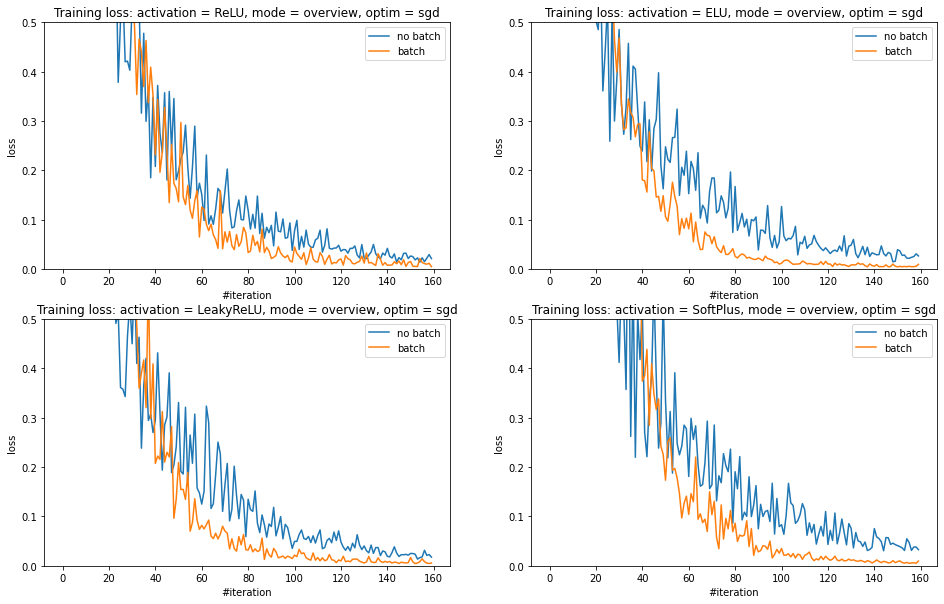

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.reshape((4,))
for i in range(4):
    visualize_net_pair(
        axs[i], 
        losses_without_batch_sgd[i][1],
        losses_with_batch_sgd[i][1], 
        str(losses_without_batch_sgd[i][0].modules[1]),
        "overview",
        "sgd"
    )

In [ ]:
overview_batch = 4000
t = Trainer(
    optimizer=adam_optimizer,
    optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
)

nets_without_batch_adam, losses_without_batch_adam = t.cross_train(
    (X_train[:overview_batch],
     y_train[:overview_batch]))
nets_with_batch_adam, losses_with_batch_adam = t.cross_train(
    (X_train[:overview_batch], 
     y_train[:overview_batch]), batch_norm=True)

Linear 784 -> 20
ReLU
Linear 20 -> 10
LogSoftMax
Flatten

Current loss: 1.572308
Current loss: 0.920159
Current loss: 0.800040
Current loss: 0.751346
Current loss: 0.437900
Current loss: 0.232549
Current loss: 0.330145
Current loss: 0.363190
Current loss: 0.268282
Current loss: 0.738002
Current loss: 0.200164
Current loss: 0.328094
Current loss: 0.071939
Current loss: 0.278655
Current loss: 0.183341
Current loss: 0.133137
Current loss: 0.194497
Current loss: 0.363644
Current loss: 0.132669
Current loss: 0.143250

Linear 784 -> 20
ELU
Linear 20 -> 10
LogSoftMax
Flatten

Current loss: 1.591836
Current loss: 0.896793
Current loss: 0.718833
Current loss: 0.578328
Current loss: 0.333728
Current loss: 0.152543
Current loss: 0.446576
Current loss: 0.408238
Current loss: 0.453871
Current loss: 0.452287
Current loss: 0.230320
Current loss: 0.325858
Current loss: 0.292456
Current loss: 0.068887
Current loss: 0.217273
Current loss: 0.081161
Current loss: 0.219168
Current loss: 0.112089
Current lo

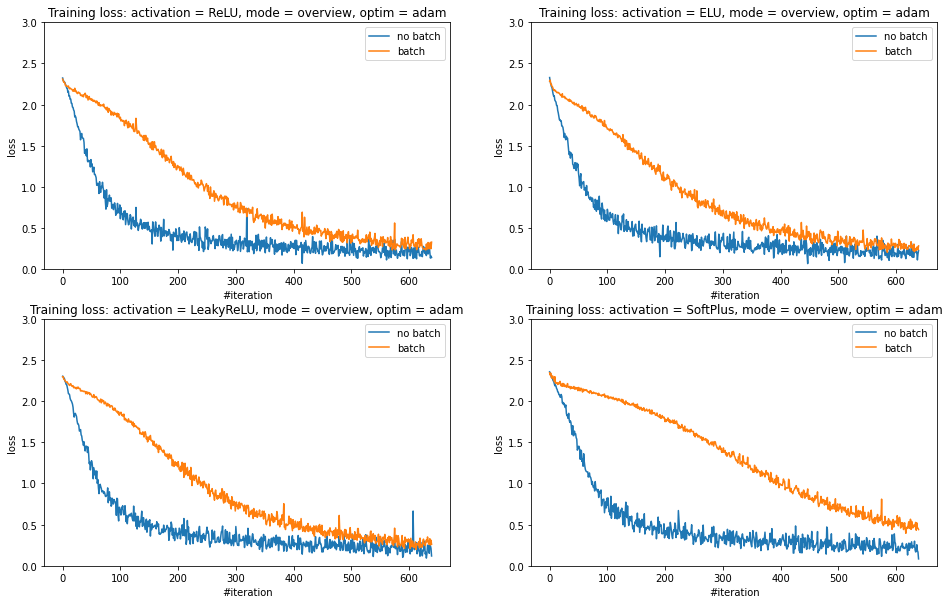

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.reshape((4,))
for i in range(4):
    visualize_net_pair(
        axs[i], 
        losses_without_batch_adam[i][1],
        losses_with_batch_adam[i][1], 
        str(losses_without_batch_adam[i][0].modules[1]),
        "overview",
        "adam",
        ylim=3
    )

In [ ]:
for net in nets_without_batch_sgd + nets_with_batch_sgd:
    print(net)
    Trainer(net).validate((X_val, y_val))
    print('================', end='\n\n')

Linear 784 -> 20
ReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8759

Linear 784 -> 20
ELU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.87

Linear 784 -> 20
LeakyReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8755

Linear 784 -> 20
SoftPlus
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.872

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
ReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8415

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
ELU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8477

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8545

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8505



In [ ]:
for net in nets_without_batch_adam + nets_with_batch_adam:
    print(net)
    Trainer(net).validate((X_val, y_val))
    print('================', end='\n\n')

Linear 784 -> 20
ReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.9133

Linear 784 -> 20
ELU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.9101

Linear 784 -> 20
LeakyReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.9125

Linear 784 -> 20
SoftPlus
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.9082

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
ReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8824

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
ELU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8794

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8845

Linear 784 -> 20
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 20 -> 10
LogSoftMax
Flatten

Accuracy: 0.8796



Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

## Personal opinion:
`BatchNormalization` does not help! Loss decreases slower, accuracy is less, computation time is same as without it

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
net = Sequential()\
    .add(Linear(784, 20))\
    .add(Dropout())\
    .add(SoftPlus())\
    .add(Linear(20, 10))\
    .add(LogSoftMax())\
    .add(Flatten())
optimizer = adam_optimizer
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
t = Trainer(net, optimizer=optimizer, optimizer_config=optimizer_config, optimizer_state={})

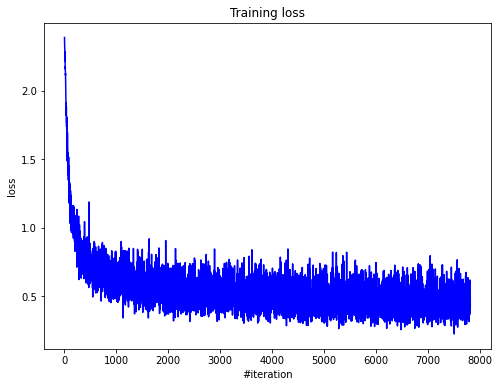

Current loss: 0.426345


(Linear 784 -> 20
 Dropout
 SoftPlus
 Linear 20 -> 10
 LogSoftMax
 Flatten,
 [2.388047411223833,
  2.333384685054244,
  2.3390012525903714,
  2.3295370548512455,
  2.32214242575519,
  2.31726606247682,
  2.300503736129395,
  2.267486140409611,
  2.2806911085842074,
  2.2142360357132507,
  2.282713370999372,
  2.2692450325145836,
  2.225948316077285,
  2.1581312407228417,
  2.20823048028933,
  2.1746963186323476,
  2.1532095555665807,
  2.162501175847801,
  2.131932086223005,
  2.1130317251028456,
  2.125080463200019,
  2.0984868131910464,
  2.1014263823644024,
  2.0115995530500665,
  2.002086606663436,
  1.9993579820769587,
  2.006592998065913,
  1.9787025603779753,
  1.9611867569841428,
  1.931883384426334,
  1.8906223034403986,
  1.8820804820915127,
  1.8170999250314224,
  1.9107442969832642,
  1.8681657144962367,
  1.8549598315861497,
  1.8828419391573945,
  1.8321738156725993,
  1.8502509825418532,
  1.74731512553145,
  1.7375099200817448,
  1.809449197249724,
  1.7640345938724584,

In [ ]:
t.train((X_train, y_train), visualize=True)

Print here your accuracy on test set. It should be around 90%.

In [ ]:
t.validate((X_test, y_test))

Accuracy: 0.9291


0.9291

In [ ]:
net_batch_norm = Sequential()\
    .add(Linear(784, 20))\
    .add(Dropout())\
    .add(BatchNormalization())\
    .add(ChannelwiseScaling(20))\
    .add(SoftPlus())\
    .add(Linear(20, 10))\
    .add(LogSoftMax())\
    .add(Flatten())
optimizer = adam_optimizer
optimizer_config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
t_batch_norm = Trainer(net_batch_norm, optimizer=optimizer, optimizer_config=optimizer_config, optimizer_state={})

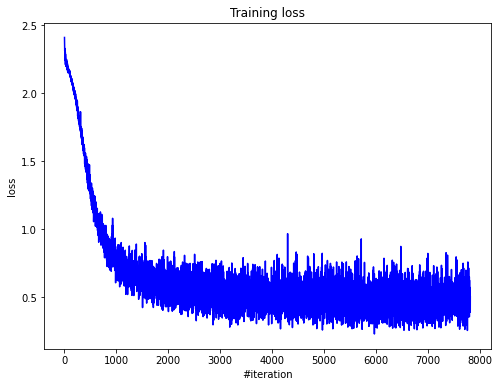

Current loss: 0.505026


(Linear 784 -> 20
 Dropout
 BatchNormalization
 ChannelwiseScaling
 SoftPlus
 Linear 20 -> 10
 LogSoftMax
 Flatten,
 [2.4105292685689625,
  2.393462483333085,
  2.3502189244215153,
  2.389366395907711,
  2.312526669600049,
  2.3331613152387627,
  2.323141121127122,
  2.329702484813561,
  2.315820428781327,
  2.2481036151848004,
  2.243908289816398,
  2.3003360634085688,
  2.263075199501988,
  2.31837446928826,
  2.2553945665387047,
  2.303480137667896,
  2.300581595930923,
  2.2709101610715012,
  2.211058880444234,
  2.288625046094642,
  2.2880978083060355,
  2.255868112520284,
  2.2654675341175654,
  2.2499401092600806,
  2.2292977577146957,
  2.213727071335715,
  2.2391974097053655,
  2.1978665086218325,
  2.249038626996517,
  2.2195462187508666,
  2.2465058299126777,
  2.2299700384152263,
  2.213252430255038,
  2.239287752686133,
  2.2345165543826258,
  2.205947874627438,
  2.2222128148945686,
  2.2345244852119697,
  2.2241029177049643,
  2.234689368719785,
  2.2097912076592126,
  2

In [ ]:
t_batch_norm.train((X_train, y_train), visualize=True)

In [ ]:
t_batch_norm.validate((X_test, y_test))

Accuracy: 0.9135


0.9135

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
from torch import nn
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

num_classes = 10

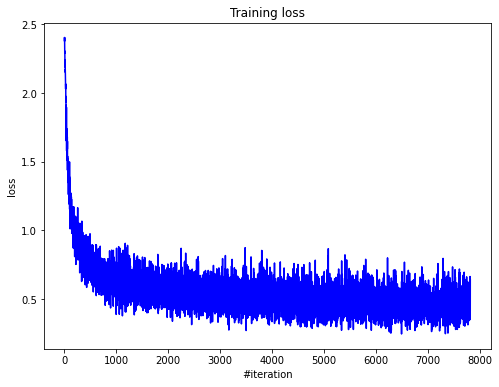

Current loss: 0.639363


(Sequential(
   (0): Flatten(start_dim=1, end_dim=-1)
   (1): Linear(in_features=784, out_features=20, bias=True)
   (2): Dropout(p=0.5, inplace=False)
   (3): Softplus(beta=1, threshold=20)
   (4): Linear(in_features=20, out_features=10, bias=True)
   (5): LogSoftmax(dim=None)
   (6): Flatten(start_dim=1, end_dim=-1)
 ),
 [2.4018468856811523,
  2.377748489379883,
  2.4052717685699463,
  2.3228421211242676,
  2.3235440254211426,
  2.2898495197296143,
  2.3066725730895996,
  2.2622551918029785,
  2.2746872901916504,
  2.229853868484497,
  2.19034743309021,
  2.2402431964874268,
  2.1567227840423584,
  2.152912139892578,
  2.1715338230133057,
  2.171886444091797,
  2.161665678024292,
  2.136448860168457,
  2.0984761714935303,
  2.0725653171539307,
  2.094787120819092,
  2.0493555068969727,
  2.0301320552825928,
  2.0668985843658447,
  2.045527458190918,
  1.9428801536560059,
  1.9339848756790161,
  1.9759613275527954,
  1.9255318641662598,
  1.933679461479187,
  1.9021358489990234,
  1.8

In [ ]:
net_torch = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 20),
    torch.nn.Dropout(),
    torch.nn.Softplus(),
    torch.nn.Linear(20, 10),
    torch.nn.LogSoftmax(),
    torch.nn.Flatten(),
)
optimizer = torch.optim.Adam(net_torch.parameters(), lr=1e-3)
t_torch = Trainer(net=net_torch, optimizer=optimizer, criterion=torch.nn.NLLLoss())
t_torch.train_torch((X_train, y_train), visualize=True)

In [ ]:
t_torch.validate_torch((X_test, y_test))

Accuracy: 0.9283


0.9283